<a href="https://colab.research.google.com/github/Genki-Hasuda/hello-world/blob/master/PoseNet_paython_sample5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#テーマ：Posenetを使った人の転倒検知

##自己紹介・所属・メンター　　
名前：蓮田　元希  
所属：東京大学前期教養過程理科一類  
メンター：川崎さん

##インターンシップの目的・目標（なぜLBで働きたいか）  
今まで定性的にしか知らなかった機械学習がどのように動いているのかを知る。  
プログラミングがどのように実務で活用されているかを知る

##インターンの内容・活動  



# PoseNet-python sample program
2020/03/05 nabezo
* use mp4 videodata on googledrive
* output to googledrive

In [1]:
# PoseNet-python
# insatll
!git clone https://www.github.com/rwightman/posenet-python
%cd posenet-python
!pip3 install tensorflow-gpu==1.15
!pip3 install scipy
!pip3 install pyyaml
!pip3 install opencv-python==3.4.5.20
!pip3 install ipykernel

Cloning into 'posenet-python'...
remote: Enumerating objects: 119, done.
remote: Total 119 (delta 0), reused 0 (delta 0), pack-reused 119
Receiving objects: 100% (119/119), 36.55 KiB | 9.14 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/posenet-python
     |████████████████████████████████| 411.5MB 43kB/s 
     |████████████████████████████████| 512kB 51.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 3.8MB 43.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=27777387265bf09ca346f4def6b70c10250936d69307c0a6966885eda3a45b00
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tenso

In [37]:
# PoseNet python sample program
import tensorflow as tf
import cv2
import time
import argparse
import os
import posenet

print('INIT:')
from google.colab import drive
drive.mount('/content/drive')
drivepath="/content/drive/My Drive/VIDEO/"
driveinfile = drivepath + 'test8.mov'
driveoutfile = drivepath + 'output16.mp4'

# VideoReaderWriter
cap = cv2.VideoCapture(driveinfile)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
#　fourcc = cv2.VideoWriter_fourcc('h','2','6', '4')
fourcc = cv2.VideoWriter_fourcc('m','p','4', 'v')
video = cv2.VideoWriter(driveoutfile, fourcc, fps, (width, height))

model = 101
###scale_factor = 1.0
scale_factor = 0.4


with tf.Session() as sess:
    print('MODEL-INIT:')
    ####model_cfg, model_outputs = posenet.load_model(args.model, sess)
    model_cfg, model_outputs = posenet.load_model(model, sess)
    output_stride = model_cfg['output_stride']
    start = time.time()
    print('START:')

    incnt = 0
    a = []
    while True:
      
        incnt = incnt + 1
        try: input_image, draw_image, output_scale = posenet.read_cap(
                cap, scale_factor=scale_factor, output_stride=output_stride)
        except:break
        heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = sess.run(
            model_outputs,
            feed_dict={'image:0': input_image}
        )
        pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
            heatmaps_result.squeeze(axis=0),
            offsets_result.squeeze(axis=0),
            displacement_fwd_result.squeeze(axis=0),
            displacement_bwd_result.squeeze(axis=0),
            output_stride=output_stride,
            max_pose_detections=10,
            min_pose_score=0.25)

        keypoint_coords *= output_scale

        draw_image = posenet.draw_skel_and_kp(
                draw_image, pose_scores, keypoint_scores, keypoint_coords,
                min_pose_score=0.25, min_part_score=0.25)
        
        
        
#  編集は上で
        video.write(draw_image)
        if incnt % 100 == 0:        
            print("cnt=", incnt, "fps=", incnt / (time.time() - start) )
            

        if True:
            #debug
            for pi in range(len(pose_scores)):
                cv.putText(draw_image, 'Flowers', (0, 50), cv.FONT_HERSHEY_PLAIN, 4, (255, 255, 255), 5, cv.LINE_AA) 
                if pose_scores[pi] == 0.:
                    break
                print('Pose #%d, score = %f' % (pi, pose_scores[pi]))
                for ki, (s, c) in enumerate(zip(keypoint_scores[pi, :], keypoint_coords[pi, :, :])):
                    print('Keypoint %s, score = %f, coord = %s' % (posenet.PART_NAMES[ki], s, c))
                    a.append(keypoint_coords[pi, :, :])
                    
video.release()
cap.release()
print('END:')
#解像度　　　縦が最初の値　


INIT:
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MODEL-INIT:
START:
Pose #0, score = 0.899314
Keypoint nose, score = 0.977979, coord = [770.98548324 554.68275597]
Keypoint leftEye, score = 0.942706, coord = [763.6565038 558.8345325]
Keypoint rightEye, score = 0.967944, coord = [763.73139579 548.08756412]
Keypoint leftEar, score = 0.662330, coord = [765.92582375 564.10642084]
Keypoint rightEar, score = 0.646345, coord = [764.31036742 539.11608742]
Keypoint leftShoulder, score = 0.985887, coord = [795.43148006 585.20415097]
Keypoint rightShoulder, score = 0.996453, coord = [800.39578273 525.81856741]
Keypoint leftElbow, score = 0.710364, coord = [851.7989021  595.19795829]
Keypoint rightElbow, score = 0.978758, coord = [845.22771114 515.34463046]
Keypoint leftWrist, score = 0.985570, coord = [865.87932096 587.37469966]
Keypoint rightWrist, score = 0.631271, coord = [899.15417893 529.44100325]
Keypoint l

In [30]:
!pip install -y python
!pip install ipa-gothic-fonts 
!pip3 install opencv-python
!pip3 install pillow


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y
ERROR: Could not find a version that satisfies the requirement ipa-gothic-fonts (from versions: none)
ERROR: No matching distribution found for ipa-gothic-fonts


In [38]:
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image
 
cap = cv2.VideoCapture('output15.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('output.m4v', fourcc, fps, (width, height))
 
while True:
    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        draw = ImageDraw.Draw(pil_image)
        font = ImageFont.truetype('/usr/share/fonts/ipa-gothic/ipag.ttf', 50)
        draw.text((50, 300), '国会議事堂', font=font)
        rgb_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
        out.write(rgb_image)
    else:
        break
 
cap.release()
out.release()

In [ ]:
score_all = [0.8993, 0.8697,  0.8933, 0.8459, 0.8715, 0.9210, 0.9207,  0.9212, 0.9076, 0.3869, 0.5156, ]
score_nose = [0.9779, 0.8984, 0.9708,  0.9056, 0.9226,  0.9756, 0.9665, 0.9381, 0.9316, 0.1712, 0.0365, ]
coord_nose_v = [770.98, 768.19, 768.88, 769.29, 768.35, 769.92, 776.34, 798.93, 859.02, 944.23, 947.41, ]
coord_nose_h = [554.68, 553.93, 559.73, 566.19, 566.19, 564.02, 563.55, 577.15, 583.23, 586.58, 565.69]
score_leftShoulder = [0.9858, 0.9843, 0.9946, 0.9962, 0.9970, 0.9969, 0.9971, 0.9943, 0.9719,  0.5826, 0.3193]
coord_leftShoulder_v = [795.43, 792.05, 796.05, 798.36, 794.63, 800.07, 804.56, 824.61, 867.26, 933.63, 942.97]
coord_leftShoulder_h = [585.20, 586.50, 578.65, 583.87, 590.36, 595.34, 594.02, 596.09, ]
score_leftHip = [0.9714, 0.9823,  0.9776, 0.9833, 0.9875, 0.9782, 0.9899,  0.9931,  0.9071,  0.5050, 0.7373]
coord_leftHip_v = [886.34, 886.61, 887.12, 890.46, 896.71, 903.24, 902.61,  922.62, 949.02, 973.95, 1013.31]
coord_leftHip_h = [570.68 , 574.02, 573.08, 575.06, 579.02, 579.77, 578.73, 583.57, ]
score_leftAnkle = [0.9578, 0.9675, 0.9877,  0.8509, 0.8280, 0.9340, 0.9281, 0.9220, 0.9760, 0.7080, 0.8954]
coord_leftAnkle_v = [1020.33, 1016.93, 1036.65,  1035.74, 1031.69, 1048.87, 1046.9, 1044.20, 1068.25, 1092.46, 1157.95]
coord_leftAnkle_h = [563.65, 565.60, 570.25, 568.76, 570.47, 568.94, 571.62, 570.90, ]
time = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]

Text(0, 0.5, 'score')

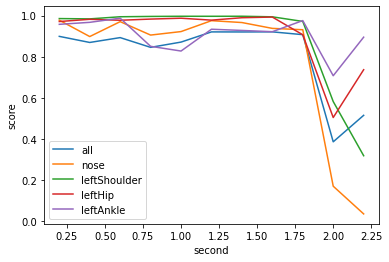

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time, score_all, label = "all")
plt.plot(time, score_nose, label = "nose")
plt.plot(time, score_leftShoulder, label = "leftShoulder")
plt.plot(time, score_leftHip, label = "leftHip")
plt.plot(time, score_leftAnkle, label = "leftAnkle")
plt.legend()
plt.xlabel("second")
plt.ylabel("score")


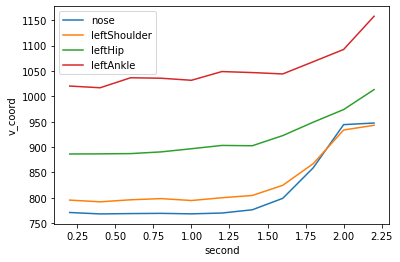

In [ ]:
plt.plot(time, coord_nose_v, label = "nose")
#plt.plot(coord_nose_h)
plt.plot(time, coord_leftShoulder_v, label = "leftShoulder")
plt.plot(time, coord_leftHip_v, label = "leftHip")
plt.plot(time, coord_leftAnkle_v, label = "leftAnkle")
plt.xlabel("second")
plt.ylabel("v_coord")
plt.legend()

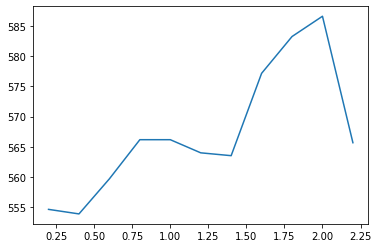

In [ ]:
{plt.plot(time, coord_nose_h, label = "ba")

全体のscoreの変動  
初めは0.8後半から0.9前半までのかなり高い数値を保っていたが、転倒すると小さくなり、0.2台まで落ち込んだ。実際出力された動画を見ても、前のめりになった時に点や線が重なっているためにscoreが下がっていることがわかった。  
特定の部位のscereのと座標の変動  
顔の代表値　nose


In [ ]:
%cd posenet-python
!ls
%cd posenet
!ls -la
!cat utils.py

[Errno 2] No such file or directory: 'posenet-python'
/content/posenet-python
benchmark.py	    image_demo.py  _models     posenet	  webcam_demo.py
get_test_images.py  LICENSE.txt    NOTICE.txt  README.md
/content/posenet-python/posenet
total 44
drwxr-xr-x 4 root root 4096 Nov  6 08:29 .
drwxr-xr-x 5 root root 4096 Nov  6 08:14 ..
-rw-r--r-- 1 root root 1991 Nov  6 08:12 constants.py
drwxr-xr-x 3 root root 4096 Nov  6 08:14 converter
-rw-r--r-- 1 root root 6080 Nov  6 08:12 decode_multi.py
-rw-r--r-- 1 root root 2731 Nov  6 08:12 decode.py
-rw-r--r-- 1 root root  152 Nov  6 08:12 __init__.py
-rw-r--r-- 1 root root 1983 Nov  6 08:12 model.py
drwxr-xr-x 2 root root 4096 Nov  6 08:14 __pycache__
-rw-r--r-- 1 root root 3884 Nov  6 08:29 utils.py
import cv2
import numpy as np

import posenet.constants


def valid_resolution(width, height, output_stride=16):
    target_width = (int(width) // output_stride) * output_stride + 1
    target_height = (int(height) // output_stride) * output_stride 